## Preamble

In [1]:
import os
import numpy as np
#from scipy import signal
import matplotlib.pyplot as plt

In [2]:
nz=201; nx=201; h=10

fPEak=7
dt=0.002
nt=2000

ntr=100

In [8]:
def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

# def read_snap(filename,n=(nsnap,nxsnap,nzsnap),i=26):
#     tmp=np.fromfile(filename,dtyPE='float32').reshaPE(n).T
#     return tmp[:,:,i]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],extent=extent,cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def run(app='../../exe/FWI',setup='setup',np=1,nthreads=8,out=None):
    '''
    run(app,setup,np=1,nthreads=8)
    run in a bash env
    ----------------------------
    app      : application/executable to run
    setup    : setup file
    np       : number of MPI processors (default=1)
    nthreads : number of OpenMP threads (default=8)
    
    Caveat: np*nthreads should not exceed total number of CPU cores
    otherwise the running will be very slow
    '''
    
    !echo 'ulimit -s unlimited' > run.sh
    str=f"export OMP_NUM_THREADS={nthreads}"
    !echo $str >> run.sh
    str=f"{app} {setup}"
    !echo $str >> run.sh
    !chmod +x run.sh
    if out==None:
        !./run.sh
    else:
        !./run.sh > {out}

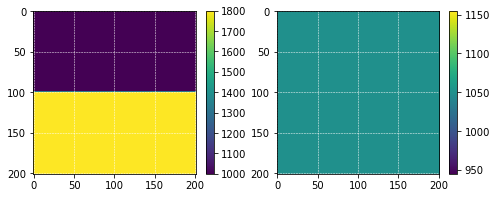

In [9]:
# True
!makevel nz=100 nx=$nx v000=1000 > c1
!makevel nz=101 nx=$nx v000=1800 > c2
!cat c1 c2 > tmp && transp < tmp n1=$nx > true
!rm c1 c2 tmp

# Background
!makevel nz=$nz nx=$nx v000=1050 > init

#plot
plt.figure(figsize=(8,3))
true=read('true'); init=read('init')
plt.subplot(1,2,1); imshow(true)
plt.subplot(1,2,2); imshow(init)

In [10]:
!cat setup_default

MODEL_SIZE              '201 201 1'
MODEL_SPACING           '10 10 1'
FILE_MODEL              true
MODEL_ATTRIBUTES        vp  #'vp rho'

IS_FREESURFACE          F

ACQUI_GEOMETRY          spread
FS                      '40 500  0'
DR                      '0  20   0'
FR                      '40 0    0'
NR                      100

SCOMP                   pz
RCOMP                   'pz px ez ex es'

WAVELET_TYPE            ricker

IF_BLOOM        F
IF_HICKS        F

IF_USE_RANDOM   F

NT           2000
DT           0.002
FPEAK        7
#RDT			0.006

#SNAPSHOT     'pz px ez ex'
#NSNAPSHOT    50

## for FWI ##
FILE_DATA_PREFIX    'results_obs/Ru_Shot'

WEIGHTING    'aoffset_range:1000:1000'

JOB           gradient


IF_USE_CHECKPOINT   F


In [11]:
#case (11); self%rcv(i)%comp='p'  !pressure

#case (12); self%rcv(i)%comp='vz' !vertical velocity
#case (14); self%rcv(i)%comp='vx' !horizontal velocity in in-line
#case (13); self%rcv(i)%comp='vy' !horizontal velocity in cross-line

#case (21); self%rcv(i)%comp='ez' !ezz
#case (22); self%rcv(i)%comp='ex' !exx
#case (23); self%rcv(i)%comp='ey' !eyy
#case (24); self%rcv(i)%comp='es' !ezx

#case (32); self%rcv(i)%comp='pz' !vertical momenta
#case (34); self%rcv(i)%comp='px' !in-line momenta
#case (33); self%rcv(i)%comp='py' !cross-line momenta

In [12]:
#!lda = rho(vp^2-2vs^2)
#!mu  = rho*vs^2
#!rho0= rho
#!gvp = glda*2rho*vp
#!gvs = (glda*-2 + gmu)*2rho*vs
#!grho= glda*vp^2 + (-2glda+gmu)*vs^2 + grho0
vp=init
vs=vp/np.sqrt(3)
rho=1000.
def gvp(glda):     return  glda            *2*rho*vp
def gvs(glda,gmu): return (glda*(-2) + gmu)*2*rho*vs

## Data

In [19]:
!cp setup_default setup
!echo "IS_FREESURFACE      T" >> setup
!echo "DIR_OUT     results_obs" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_GradientCompar
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 641800 Nov  9 15:37 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 6b4572c
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/09/2023
System time: 16:05:25
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs
 Output directory:results_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/

In [20]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "IS_FREESURFACE      T" >> setup
!echo "DIR_OUT     results_syn" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_GradientCompar
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 641800 Nov  9 15:37 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 6b4572c
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/09/2023
System time: 16:05:32
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_syn
 Output directory:results_syn/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/

In [21]:
!cp setup_default setup
!echo "DIR_OUT     results_obs_VS" >> setup
!echo "IS_FREESURFACE      T" >> setup
!echo 'SCOMP       vz' >> setup
!echo 'RCOMP       vx' >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_GradientCompar
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 625384 Nov  9 15:37 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 6b4572c
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/09/2023
System time: 16:05:36
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs_VS
 Output directory:results_obs_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 

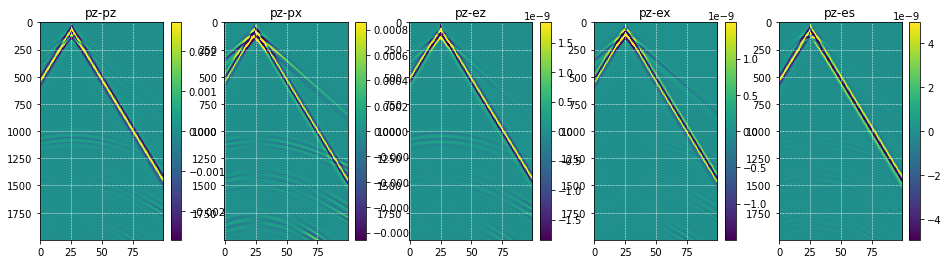

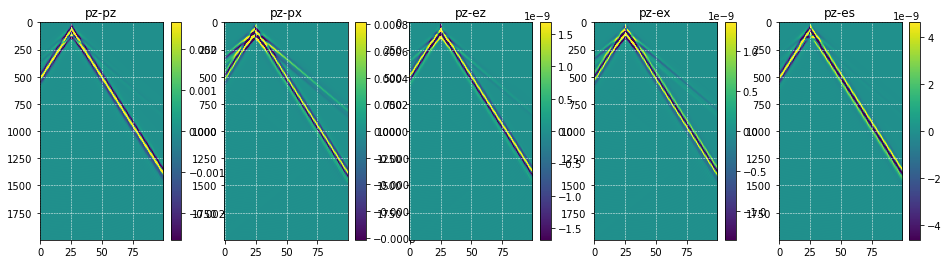

In [22]:
data=read_su('results_obs/Ru_Shot0001.su',n=(5*ntr,nt))

plt.figure(figsize=(16,4))
plt.subplot(1,5,1); imshow(data[:,     :ntr],title='pz-pz',perc=98)
plt.subplot(1,5,2); imshow(data[:,  ntr:2*ntr],title='pz-px',perc=98)
plt.subplot(1,5,3); imshow(data[:,2*ntr:3*ntr],title='pz-ez',perc=98)
plt.subplot(1,5,4); imshow(data[:,3*ntr:4*ntr],title='pz-ex',perc=98)
plt.subplot(1,5,5); imshow(data[:,4*ntr:5*ntr],title='pz-es',perc=98)

data=read_su('results_syn/Ru_Shot0001.su',n=(5*ntr,nt))

plt.figure(figsize=(16,4))
plt.subplot(1,5,1); imshow(data[:,     :ntr],title='pz-pz',perc=98)
plt.subplot(1,5,2); imshow(data[:,  ntr:2*ntr],title='pz-px',perc=98)
plt.subplot(1,5,3); imshow(data[:,2*ntr:3*ntr],title='pz-ez',perc=98)
plt.subplot(1,5,4); imshow(data[:,3*ntr:4*ntr],title='pz-ex',perc=98)
plt.subplot(1,5,5); imshow(data[:,4*ntr:5*ntr],title='pz-es',perc=98)

### px-ex conversion

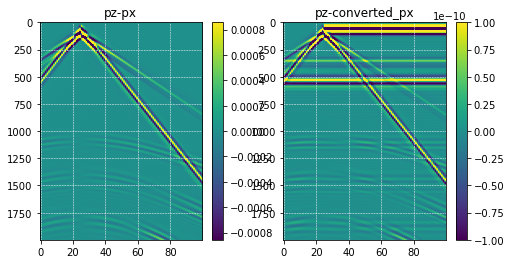

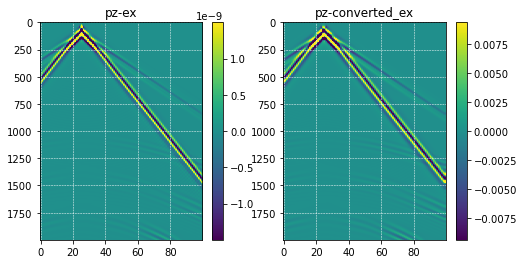

In [28]:
data=read_su('results_obs/Ru_Shot0001.su',n=(5*ntr,nt))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(data[:,ntr:2*ntr],title='pz-px',perc=98)
plt.subplot(1,2,2); imshow(np.gradient(np.cumsum(data[:,3*ntr:4*ntr],axis=1),axis=0),
                           title='pz-converted_px',clip=(-1e-10,1e-10))
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(data[:,3*ntr:4*ntr],title='pz-ex',perc=98)
plt.subplot(1,2,2); imshow(np.cumsum(np.gradient(data[:,ntr:2*ntr],axis=1),axis=0),
                           title='pz-converted_ex',perc=98)

### P-E vs V-S

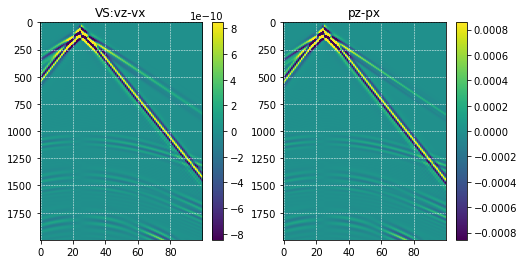

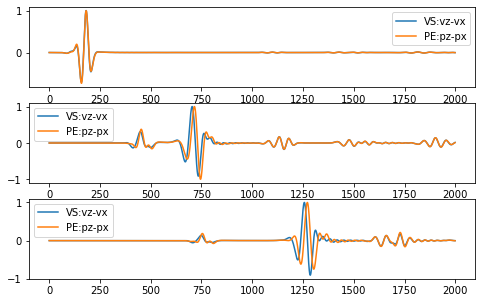

In [23]:
plt.figure(figsize=(8,4))

data=read_su('results_obs_VS/Ru_Shot0001.su',n=(ntr,nt))
plt.subplot(1,2,1); imshow(data,title='VS:vz-vx',perc=98)

data=read_su('results_obs/Ru_Shot0001.su',n=(5*ntr,nt))
plt.subplot(1,2,2); imshow(data[:,ntr:2*ntr],title='pz-px',perc=98)

data1=read_su('results_obs_VS/Ru_Shot0001.su',n=(ntr,nt))
data2=read_su('results_obs/Ru_Shot0001.su',n=(5*ntr,nt))[:,ntr:2*ntr]

plt.figure(figsize=(8,5))
plt.subplot(3,1,1); itr=20
tr=data1[:,itr]; plt.plot(tr/np.amax(tr),label='VS:vz-vx')
tr=data2[:,itr]; plt.plot(tr/np.amax(tr),label='PE:pz-px')
plt.legend()

plt.subplot(3,1,2); itr=60
tr=data1[:,itr]; plt.plot(tr/np.amax(tr),label='VS:vz-vx')
tr=data2[:,itr]; plt.plot(tr/np.amax(tr),label='PE:pz-px')

plt.legend()
plt.subplot(3,1,3); itr=90
tr=data1[:,itr]; plt.plot(tr/np.amax(tr),label='VS:vz-vx')
tr=data2[:,itr]; plt.plot(tr/np.amax(tr),label='PE:pz-px')
plt.legend()

We got diff dispersion due to FS

## pz-pz SK

### P-E

In [29]:
!suwind < results_obs/Ru_Shot0001.su key=trid min=32 max=32 > data_0001.su

!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "IS_FREESURFACE      T" >> setup
!echo 'FILE_DATA_PREFIX   data_' >> setup
!echo "DIR_OUT     results_PE" >> setup
run(app='../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_GradientCompar
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 969624 Nov  9 15:37 ../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 6b4572c
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/09/2023
System time: 16:13:27
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_PE
 Output directory:results_PE/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diago

 it----         500
 fld_a minmax values:  -8.56327388E-05   7.56582158E-05
 fld_u minmax values:  -5.37847541E-03   1.00628529E-02
 Elapsed time to load boundary               3.58345509E-02
 Elapsed time to update strains             0.422442675    
 Elapsed time to rm source strains           2.08139420E-03
 Elapsed time to update momenta             0.545041800    
 Elapsed time to rm source momenta           4.84848022E-03
 Elapsed time ----------------------------
 Elapsed time to add adjsource strains       6.69264793E-03
 Elapsed time to update adj strains         0.405721188    
 Elapsed time to add adjsource momenta       1.11465454E-02
 Elapsed time to update adj momenta         0.548933506    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   9.13095474E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


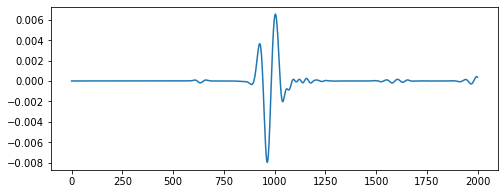

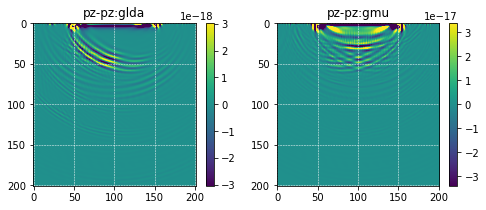

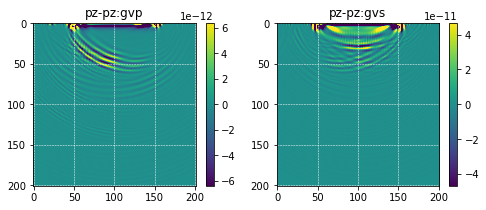

In [30]:
comp='pz-pz'

plt.figure(figsize=(8,3))
plt.plot(read_su('results_PE/dadj_Shot0001.su')[:,75])

glda=read('results_PE/a_star_u%glda')
gmu =read('results_PE/a_star_u%gmu' )

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(glda,title=comp+':glda',perc=98)
plt.subplot(1,2,2); imshow(gmu ,title=comp+':gmu' ,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(gvp(glda),title=comp+':gvp',perc=98)
plt.subplot(1,2,2); imshow(gvs(glda,gmu),title=comp+':gvs',perc=98)

## surface DAS SK

### vz-vx by V-S

In [31]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "IS_FREESURFACE      T" >> setup
!echo "FILE_DATA_PREFIX   'results_obs_VS/Ru_Shot'" >> setup
!echo 'SCOMP       vz' >> setup
!echo "DIR_OUT     results_VS" >> setup
run(app='../../exe/fwi_PSV_FDSG_O4_velocities-density_Wolfe_NLCG')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_GradientCompar
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 948784 Nov  9 15:37 ../../exe/fwi_PSV_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 6b4572c
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/09/2023
System time: 16:13:53
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_VS
 Output directory:results_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diago

 it----         500
 fld_a minmax values:  -7.49462114E-18   7.49223058E-18
 fld_u minmax values:  -7.04332415E-09   1.18009291E-08
 Elapsed time to load boundary               3.07695866E-02
 Elapsed time to update stresses            0.697058678    
 Elapsed time to rm source stresses          3.86023521E-03
 Elapsed time to update velocities          0.598450899    
 Elapsed time to rm source velocities        4.02450562E-04
 Elapsed time ----------------------------
 Elapsed time to add adjsource stresses      2.37035751E-03
 Elapsed time to update adj stresses        0.626748562    
 Elapsed time to add adjsource velocities    1.23062134E-02
 Elapsed time to update adj velocities      0.568282843    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   2.53748894E-02
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


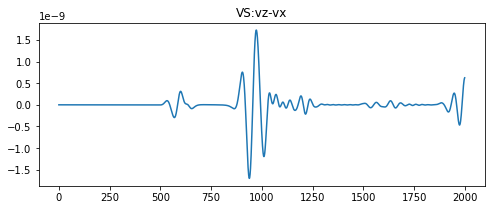

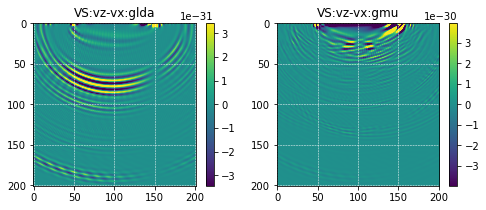

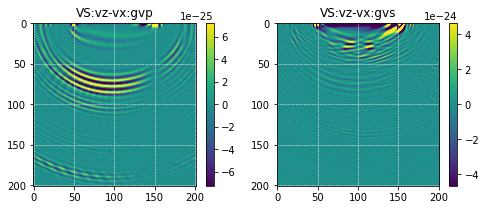

In [32]:
comp='VS:vz-vx'

plt.figure(figsize=(8,3))
plt.plot(read_su('results_VS/dadj_Shot0001.su')[:,75]); plt.title(comp)

glda=read('results_VS/a_star_u%glda')
gmu =read('results_VS/a_star_u%gmu' )

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(glda,title=comp+':glda',perc=98)
plt.subplot(1,2,2); imshow(gmu ,title=comp+':gmu' ,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(gvp(glda),title=comp+':gvp',perc=98)
plt.subplot(1,2,2); imshow(gvs(glda,gmu),title=comp+':gvs',perc=98)

### pz-px

In [33]:
!suwind < results_obs/Ru_Shot0001.su key=trid min=34 max=34 > data_0001.su

!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "IS_FREESURFACE      T" >> setup
!echo 'FILE_DATA_PREFIX   data_' >> setup
!echo "DIR_OUT     results_PE_pz-px" >> setup
run(app='../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_GradientCompar
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 969624 Nov  9 15:37 ../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 6b4572c
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/09/2023
System time: 16:14:19
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_PE_pz-px
 Output directory:results_PE_pz-px/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /re

 it----         500
 fld_a minmax values:  -7.57137195E-06   7.57155476E-06
 fld_u minmax values:  -5.37847541E-03   1.00628529E-02
 Elapsed time to load boundary               2.69198418E-02
 Elapsed time to update strains             0.484865665    
 Elapsed time to rm source strains           4.35805321E-03
 Elapsed time to update momenta             0.616881847    
 Elapsed time to rm source momenta           1.25980377E-03
 Elapsed time ----------------------------
 Elapsed time to add adjsource strains       1.01127625E-02
 Elapsed time to update adj strains         0.524328470    
 Elapsed time to add adjsource momenta       9.58967209E-03
 Elapsed time to update adj momenta         0.661231756    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   5.32865524E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


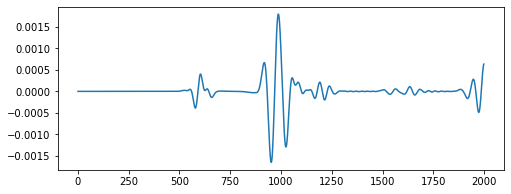

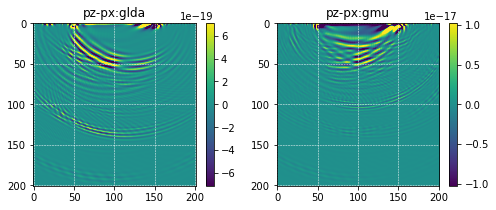

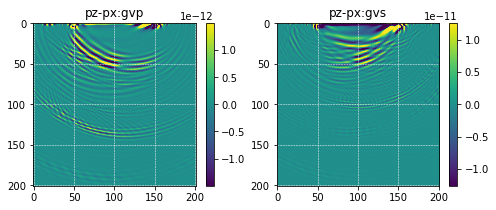

In [34]:
comp='pz-px'

plt.figure(figsize=(8,3))
plt.plot(read_su('results_PE_pz-px/dadj_Shot0001.su')[:,75])

glda=read('results_PE_pz-px/a_star_u%glda')
gmu =read('results_PE_pz-px/a_star_u%gmu' )

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(glda,title=comp+':glda',perc=98)
plt.subplot(1,2,2); imshow(gmu ,title=comp+':gmu' ,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(gvp(glda),title=comp+':gvp',perc=98)
plt.subplot(1,2,2); imshow(gvs(glda,gmu),title=comp+':gvs',perc=98)

### pz-ex

In [35]:
!suwind < results_obs/Ru_Shot0001.su key=trid min=22 max=22 > data_0001.su

!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "IS_FREESURFACE      T" >> setup
!echo 'FILE_DATA_PREFIX   data_' >> setup
!echo "DIR_OUT     results_PE" >> setup
run(app='../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/05_GradientCompar
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 969624 Nov  9 15:37 ../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 6b4572c
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/09/2023
System time: 16:14:35
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_PE
 Output directory:results_PE/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diago

 it----         500
 fld_a minmax values:  -1.76289444E-17   1.66121938E-17
 fld_u minmax values:  -5.37847541E-03   1.00628529E-02
 Elapsed time to load boundary               3.49073410E-02
 Elapsed time to update strains             0.589861393    
 Elapsed time to rm source strains           2.59685516E-03
 Elapsed time to update momenta             0.800234318    
 Elapsed time to rm source momenta           4.15277481E-03
 Elapsed time ----------------------------
 Elapsed time to add adjsource strains       1.00817680E-02
 Elapsed time to update adj strains         0.565207481    
 Elapsed time to add adjsource momenta       3.33499908E-03
 Elapsed time to update adj momenta         0.730883121    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   7.12823868E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


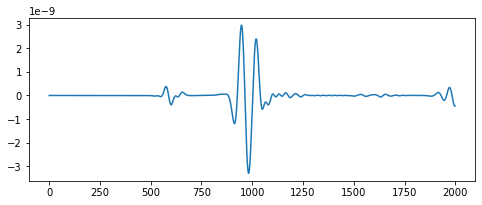

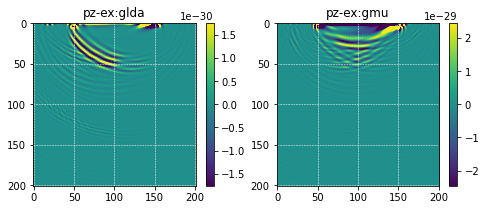

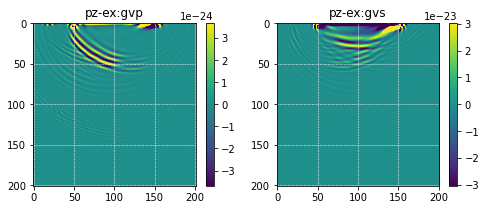

In [36]:
comp='pz-ex'

plt.figure(figsize=(8,3))
plt.plot(read_su('results_PE/dadj_Shot0001.su')[:,75])

glda=read('results_PE/a_star_u%glda')
gmu =read('results_PE/a_star_u%gmu' )

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(glda,title=comp+':glda',perc=98)
plt.subplot(1,2,2); imshow(gmu ,title=comp+':gmu' ,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(gvp(glda),title=comp+':gvp',perc=98)
plt.subplot(1,2,2); imshow(gvs(glda,gmu),title=comp+':gvs',perc=98)

### Compar

Text(0.5, 1.0, 'PE:pz-px')

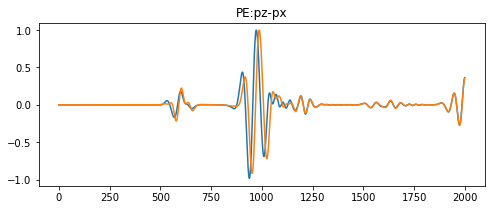

In [38]:
plt.figure(figsize=(8,3))
tr=read_su('results_VS/dadj_Shot0001.su')[:,75];       plt.plot(tr/np.amax(tr)); plt.title('VS:vz-vx')
tr=read_su('results_PE_pz-px/dadj_Shot0001.su')[:,75]; plt.plot(tr/np.amax(tr)); plt.title('PE:pz-px')

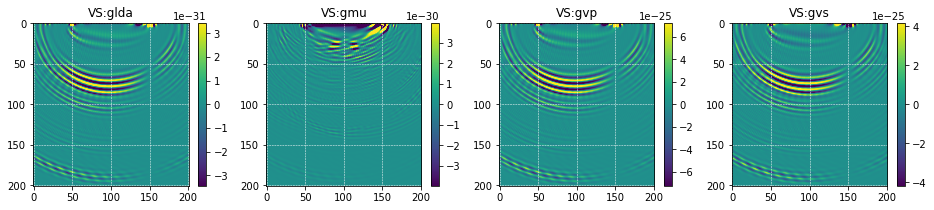

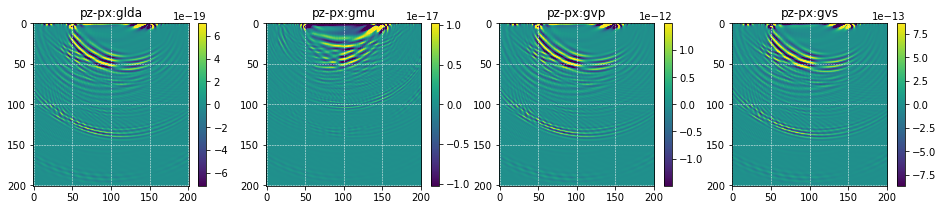

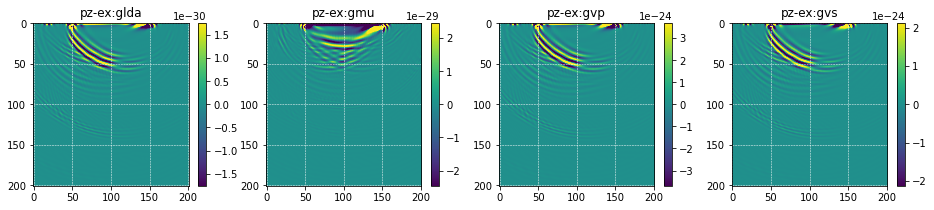

In [39]:
glda=read('results_VS/a_star_u%glda')
gmu =read('results_VS/a_star_u%gmu' )

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(glda,title='VS:glda',perc=98)
plt.subplot(1,4,2); imshow(gmu ,title='VS:gmu' ,perc=98)
plt.subplot(1,4,3); imshow(gvp(glda),     title='VS:gvp',perc=98)
plt.subplot(1,4,4); imshow(gvs(glda,glda),title='VS:gvs' ,perc=98)

glda=read('results_PE_pz-px/a_star_u%glda')
gmu =read('results_PE_pz-px/a_star_u%gmu' )

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(glda,title='pz-px:glda',perc=98)
plt.subplot(1,4,2); imshow(gmu ,title='pz-px:gmu' ,perc=98)
plt.subplot(1,4,3); imshow(gvp(glda),     title='pz-px:gvp',perc=98)
plt.subplot(1,4,4); imshow(gvs(glda,glda),title='pz-px:gvs' ,perc=98)

glda=read('results_PE/a_star_u%glda')
gmu =read('results_PE/a_star_u%gmu' )

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(glda,title='pz-ex:glda',perc=98)
plt.subplot(1,4,2); imshow(gmu ,title='pz-ex:gmu' ,perc=98)
plt.subplot(1,4,3); imshow(gvp(glda),     title='pz-ex:gvp',perc=98)
plt.subplot(1,4,4); imshow(gvs(glda,glda),title='pz-ex:gvs' ,perc=98)